In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [101]:
tslad = pd.read_csv('TSLA.csv')
tsla_df = pd.DataFrame(tslad)

# Convert 'Date' column to datetime
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'])
# Set 'Date' as the index
tsla_df.set_index('Date', inplace=True)

tsla_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500


<Axes: xlabel='Date'>

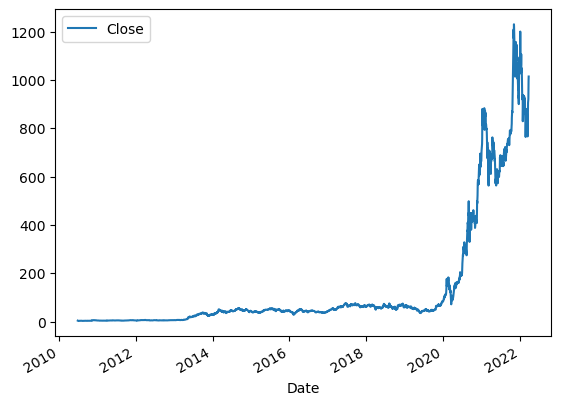

In [103]:
tsla_df.plot.line(y = 'Close', use_index = True)

In [131]:
tsla_df['Tomorrow'] = tsla_df['Close'].shift(-1)
tsla_df['Target'] = (tsla_df['Tomorrow'] < tsla_df['Close']).astype(int)
tsla_df
tsla_df.to_csv('tsla_df.csv', index=True)

In [107]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 42)

In [129]:
X = tsla_df.drop(columns=['Adj Close', 'Tomorrow', 'Target'])
y = tsla_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print("\nShapes After Splitting:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

# Saves the preprocessed dataset to a csv file
X_train.to_csv('X_train.csv', index=True)
X_test.to_csv('X_test.csv', index=True)
y_train.to_csv('y_train.csv', index=True)
y_test.to_csv('y_test.csv', index=True)

TypeError: got an unexpected keyword argument 'index'

In [111]:
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=100, random_state=42)

In [113]:
from sklearn.metrics import accuracy_score, precision_score, mean_absolute_error, mean_squared_error,r2_score, accuracy_score, confusion_matrix

preds = model.predict(X_test)
preds = pd.Series(preds, index = X_test.index)
preds

Date
2019-11-18    1
2019-11-19    1
2019-11-20    1
2019-11-21    1
2019-11-22    1
             ..
2022-03-18    1
2022-03-21    1
2022-03-22    1
2022-03-23    1
2022-03-24    1
Length: 592, dtype: int32

In [115]:
precision_score(y_test, preds)

0.4425385934819897

In [117]:
accuracy_score(y_test, preds)

0.44594594594594594

In [119]:
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)


print("Model Evaluation")
print(f"MAE model : {mae:.2f}")
print(f"MSE model : {mse:.2f}")
print(f"RMSE model : {rmse:.2f}")
print(f"R2 model : {r2:.2f}")
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Evaluation
MAE model : 0.55
MSE model : 0.55
RMSE model : 0.74
R2 model : -1.25
Model Accuracy: 44.59%


<Axes: xlabel='Date'>

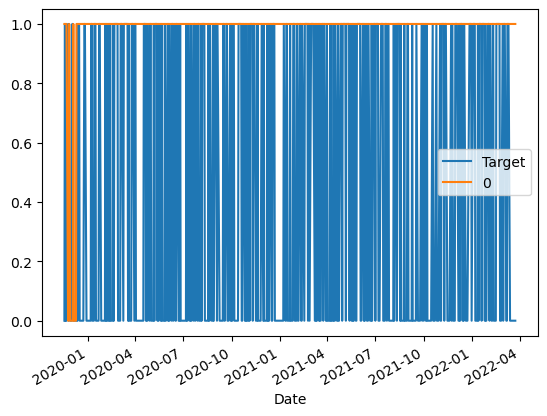

In [73]:
combined = pd.concat([y_test, preds], axis = 1)

combined.plot()

In [25]:
def predict(train, test, X, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = pd.Series(preds, index=X_test.index, name="Predictions")
    combined = pd.concat([y_test, preds], axis=1)
    return combined

In [47]:
def backtest(data, model, X, start=250, step=25):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, X, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [49]:
predictions = backtest(tsla_df, model, X)

In [50]:
predictions["Predictions"].value_counts()

Predictions
0    40112
1    24416
Name: count, dtype: int64

In [51]:
precision_score(predictions["Target"], predictions["Predictions"])

0.46875